In [258]:
%load_ext autoreload
%autoreload 2

from mcmc_lotte import *
import numpy as np
import matplotlib.pyplot as plt
import powerlaw
import csv
import pandas as pd
import itertools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
test_name = 'lotte_test'

In [28]:
temperatures = np.linspace(0.5, 50, 50)

In [10]:
means_mag, stds_mag, means_sus, stds_sus = run_simulation(1, 5000, temperatures, 10)

In [61]:
ns = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
tcs = []
peaks = []
for n in ns:
    means_mag, stds_mag, means_sus, stds_sus = run_simulation(10, 5000, temperatures, n)
    idx = np.argmax(means_sus)
    tcs.append(temperatures[idx])
    peaks.append(means_sus[idx])


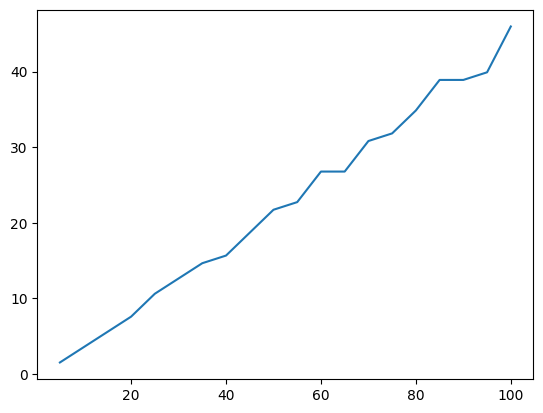

In [62]:
plt.plot(ns, tcs)

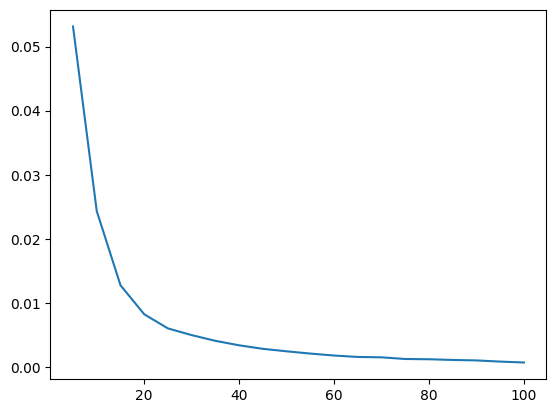

In [63]:
plt.plot(ns, peaks)

In [50]:
results = powerlaw.Fit(peaks)
print(results.power_law.alpha)
print(results.power_law.xmin)
R, p = results.distribution_compare( 'power_law',  'lognormal')
R, p

Calculating best minimal value for power law fit
15.702521077410944
26.587155194644822


(-0.401863331391656, 0.5621105047522933)

In [4]:
with open('DTI_avg_log.csv', 'r') as file:
    reader = csv.reader(file, delimiter=',')
    data = list(reader)
DTI_log = pd.DataFrame(data, dtype = 'float64')
dti_c_matrix = DTI_log.values
dti_c_matrix
n = 90

In [33]:
temperatures = np.linspace(5, 25, 50)
sim_data = run_simulation(70, 10000, temperatures, n, dti_c_matrix)
idx = np.argmax(sim_data[2])
temperatures[idx]

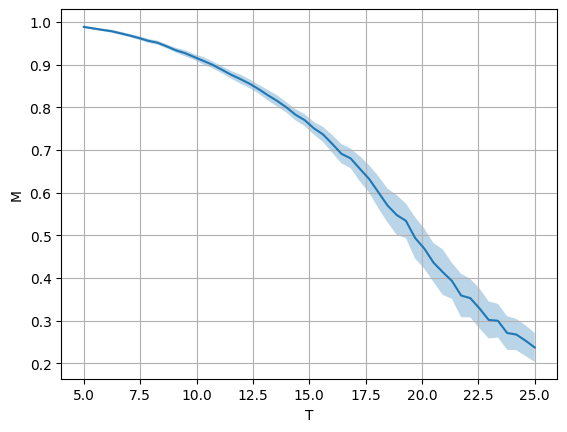

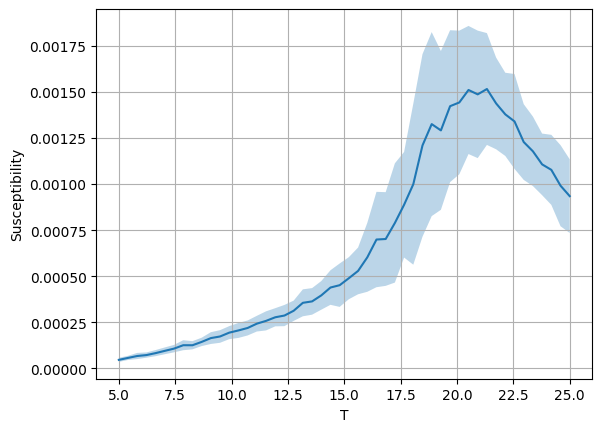

In [35]:
plot_results(sim_data, temperatures, test_name, save=False)

In [76]:
with open('fMRI_avg.csv', 'r') as file:
    reader = csv.reader(file, delimiter=',')
    data = list(reader)
fMRI = pd.DataFrame(data, dtype = 'float64')
fmri_c_matrix = fMRI.values
n = 90

In [95]:
temperatures = np.linspace(0.01, 50, 50)
sim_data = run_simulation(30, 5000, temperatures, n, fmri_c_matrix)

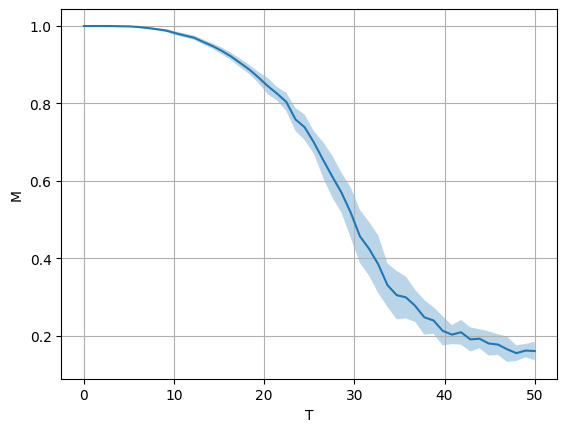

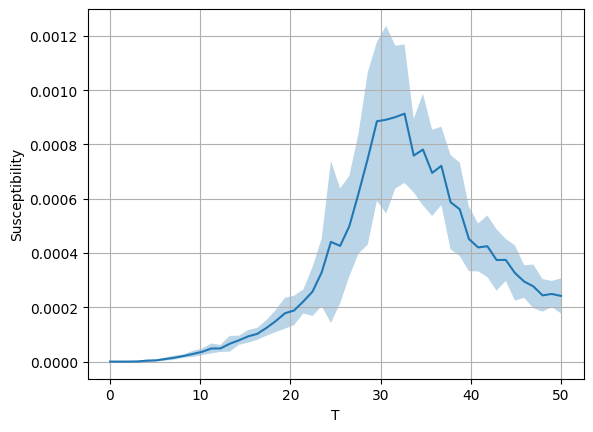

In [96]:
plot_results(sim_data, temperatures, test_name, save=False)

In [259]:
@njit
def TE(spins_timeseries, n, combos):
    c_total = 0
    
    for i in range(0, n):
        for j in range(0, n):
            
            count_array = get_probability([i,j], spins_timeseries, combos)
            possibility_list = count_array / (spins_timeseries.shape[0]-1)
            
            c = 0
            for pb in possibility_list:
                if pb[3] != 0:
                    c += pb[3] * np.log((pb[1] * pb[2]) / (pb[3] * pb[0]))
                else: 
                    c += 0

            if not np.isnan(c):
                c_total += c
        
    return c_total

In [270]:
n = 90
n_iterations = 3000
T = 40
combos = list(itertools.product([-1, 1], repeat=3))
spins = random_spins(n)
J = conn_matrix_basic(n)
_, list_avg_magnetisation, list_sus, spins_timeseries = metropolis(spins, n_iterations, T, J)


In [271]:
TE(spins_timeseries, n, combos)

-4.933803645397156

In [278]:
n = 10
n_iterations = 3000
runs = 10
combos = list(itertools.product([-1, 1], repeat=3))
C = []
C_std = []
temperatures = np.linspace(1, 10, 30)
J = conn_matrix_basic(n)
for T in temperatures:
    x = np.zeros(runs)
    for i in range(0, runs):
        spins = random_spins(n)        
        _, list_avg_magnetisation, list_sus, spins_timeseries = metropolis(spins, n_iterations, T, J) 
        x[i] = TE(spins_timeseries, n, combos)
    C_std.append(np.std(x))
    C.append(np.abs(np.mean(x)))

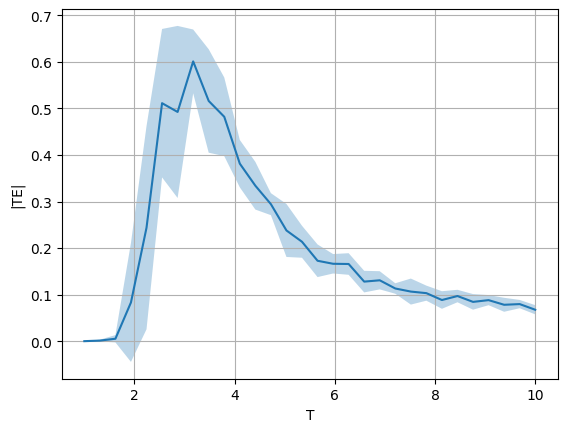

In [281]:
lower_bound = np.subtract(C, C_std)
upper_bound = np.add(C, C_std)
plt.plot(temperatures, C)
plt.fill_between(temperatures, lower_bound, upper_bound, alpha=0.3)

plt.ylabel('|TE|')
plt.xlabel('T')
plt.grid()
plt.savefig('10_nodes_TE.png', bbox_inches='tight')